<a href="https://colab.research.google.com/github/mfilipak/FILIPAK-DATA-SCIENCE/blob/main/DIA5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AULA 05 - GERADORES E AUGMENTATION


### PARTE 1 - Carregar um modelo pré-treinado para classificação IMAGENET

In [80]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from glob import glob
import random
import cv2

# Carregar o modelo MobileNetV2 pré-treinado na ImageNet
model = MobileNetV2(weights='imagenet')



### PARTE 2 - Carregar um dataset com imagens de fogo e não fogo (https://github.com/cair/Fire-Detection-Image-Dataset)

In [81]:
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Fire%20images.rar?raw=true' -O fire_images.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%201.rar?raw=true' -O non_fire_images_01.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%202.rar?raw=true' -O non_fire_images_02.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%203.rar?raw=true' -O non_fire_images_03.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%204.rar?raw=true' -O non_fire_images_04.rar
!wget 'https://github.com/cair/Fire-Detection-Image-Dataset/blob/master/Normal%20Images%205.rar?raw=true' -O non_fire_images_05.rar
clear_output()


In [3]:
!unrar x fire_images.rar /content/fire/ -y
!unrar x non_fire_images_01.rar /content/nonfire/ -y
!unrar x non_fire_images_02.rar /content/nonfire/ -y
!unrar x non_fire_images_03.rar /content/nonfire/ -y
!unrar x non_fire_images_04.rar /content/nonfire/ -y
!unrar x non_fire_images_05.rar /content/nonfire/ -y
clear_output()


In [82]:
fire_list = sorted(glob("./fire/**/*.*", recursive=True))
nonfire_list = sorted(glob("./nonfire/**/*.*", recursive=True))
print(len(fire_list), len(nonfire_list))

110 541


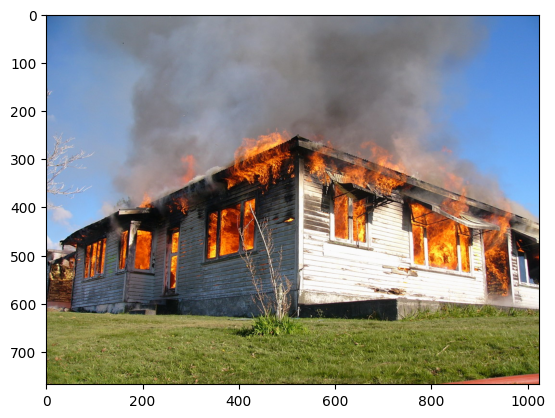

In [83]:
for f in fire_list[15:16]:
  img = cv2.imread(f)[...,::-1]
  plt.imshow(img)
  plt.show()

### PARTE 3 - Prediçoes do modelo pré-treinado

[('n09472597', 'volcano', 0.31863254), ('n09288635', 'geyser', 0.13066456), ('n03388043', 'fountain', 0.05716489)]


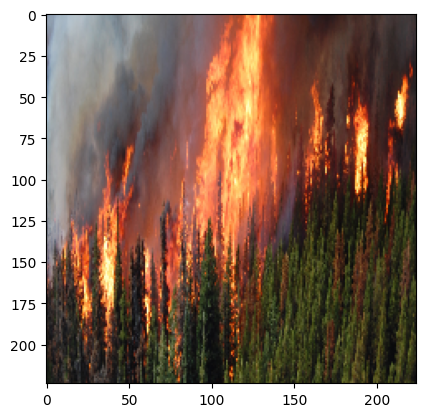

[('n03347037', 'fire_screen', 0.24925537), ('n09472597', 'volcano', 0.0676855), ('n02939185', 'caldron', 0.037805747)]


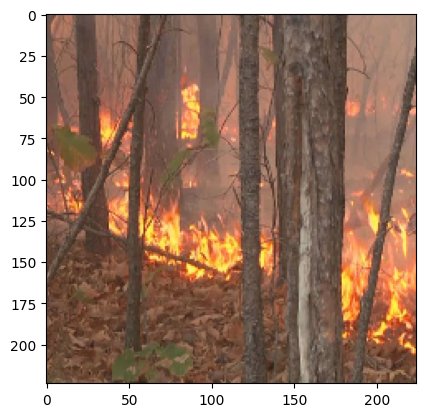

[('n09472597', 'volcano', 0.1717653), ('n03891251', 'park_bench', 0.09234787), ('n03837869', 'obelisk', 0.0801817)]


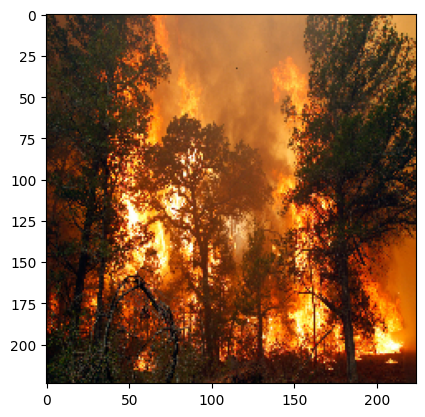

[('n09193705', 'alp', 0.2965198), ('n09468604', 'valley', 0.2223837), ('n09472597', 'volcano', 0.07564994)]


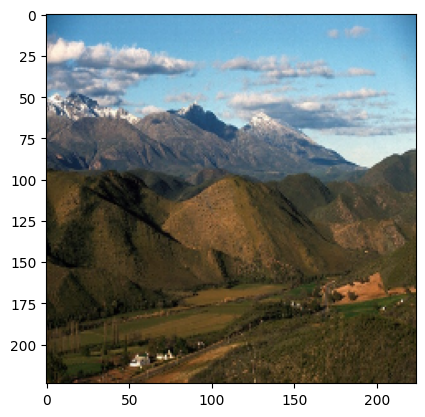

[('n03776460', 'mobile_home', 0.80780023), ('n02859443', 'boathouse', 0.0917985), ('n09332890', 'lakeside', 0.007395844)]


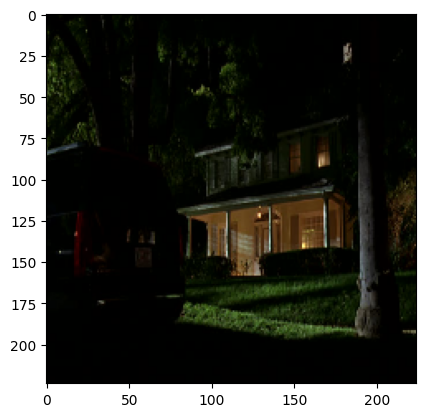

[('n03630383', 'lab_coat', 0.3072474), ('n03179701', 'desk', 0.13154782), ('n04004767', 'printer', 0.059174906)]


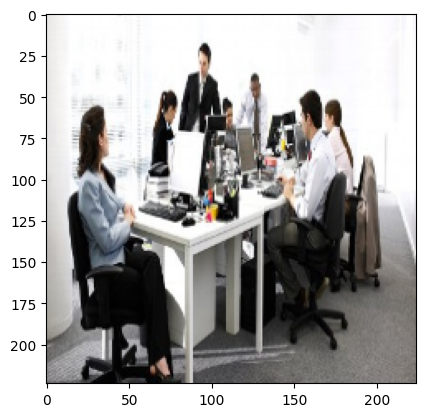

In [85]:
random.seed(41)
for f in random.sample(fire_list,3)+random.sample(nonfire_list,3):
  img = cv2.resize(cv2.imread(f)[...,::-1],(224,224))
  x = (2*(img[None,...]/255)-1).astype("float32") #Normalização min=-1,max=1
  y = model.predict(x, verbose=False)


  print(decode_predictions(y,top=3)[0])
  plt.imshow(img)
  plt.show()

In [ ]:
#preds = model.predict(preprocess_input(img)[None,...], verbose=False)
#print('Predicted:', decode_predictions(preds, top=3)[0])

### PARTE 4 - Extrai do modelo MOBILENET o submodelo do "vetor latente"

In [87]:
model.layers[-5:], model.layers[-2]

([<keras.src.layers.convolutional.conv2d.Conv2D at 0x792e5350a620>,
 <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D at 0x792e534d7b50>)

In [88]:
submodel = Model(inputs=model.input, outputs=model.layers[-2].output)

In [89]:
submodel.layers[-5:], submodel.output_shape

([<keras.src.layers.normalization.batch_normalization.BatchNormalization at 0x792e534aace0>,
 (None, 1280))

In [90]:
submodel.predict(x)

1/1 [==============================] - 1s 894ms/step


array([[0.31421116, 0.6198122 , 1.1915922 , ..., 0.13191028, 0.01676458,
        0.        ]], dtype=float32)

# AUGMENTATIONS

In [91]:
import albumentations as A

In [92]:
img = cv2.imread(nonfire_list[0])[...,::-1]

In [98]:
myfn = A.RandomBrightnessContrast(0.3, p=1)
myfn(image=img)["image"].shape

(1087, 1500, 3)

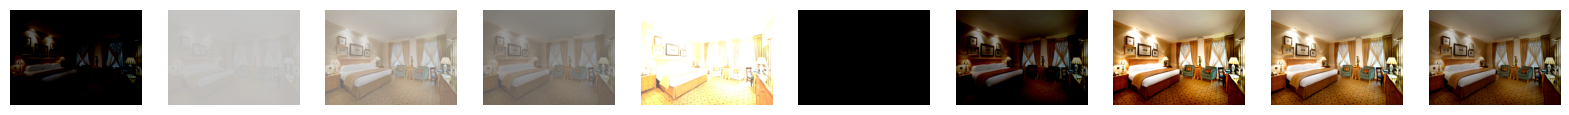

In [99]:
plt.figure(figsize=(20,5))
for i in range(10):
  plt.subplot(1,10,i+1), plt.axis("off")
  plt.imshow(A.RandomBrightnessContrast(1,1,p=1)(image=img)["image"])

In [ ]:
1,0,-1,

1
0
-1

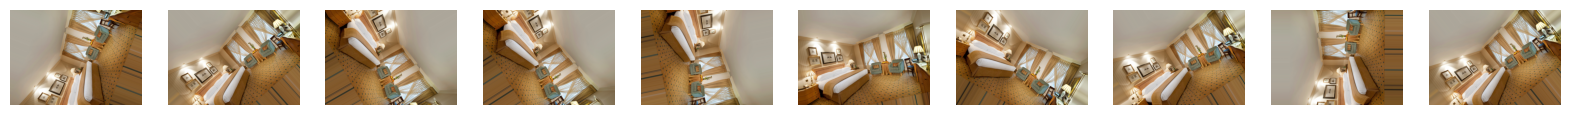

In [102]:
plt.figure(figsize=(20,5))
for i in range(10):
  plt.subplot(1,10,i+1), plt.axis("off")
  plt.imshow(A.Rotate(p=1, border_mode=cv2.BORDER_REPLICATE)(image=img)["image"])
plt.show()

In [113]:
transform = A.Compose(
    [ A.RandomBrightnessContrast(p=1),
    A.Rotate(p=1),
    A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1),
    A.Resize(224,224)
    ]
)

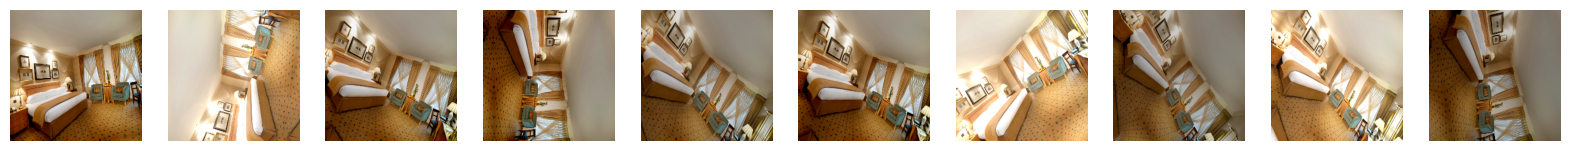

In [114]:
plt.figure(figsize=(20,5))
for i in range(10):
  plt.subplot(1,10,i+1), plt.axis("off")
  plt.imshow(transform(image=img)["image"])
plt.show()

### PARTE 5 - GERADOR

In [117]:
all_list = [[_,1] for _ in fire_list]+[[_,0] for _ in nonfire_list]


In [121]:
X = np.array(all_list)[...,0]
Y = np.array(all_list)[...,1]
X[:3],Y[:3]

(array(['./fire/Fire images/1.jpg', './fire/Fire images/10-9-15-2-400.jpg',
        './fire/Fire images/11_10_19-mjs_ft_hotel-fire_19183862.jpg'],
       dtype='<U238'),
 array(['1', '1', '1'], dtype='<U238'))

In [130]:
len(X),len(Y)

(651, 651)

In [132]:
size_test=5
idx = list(range(len(X)))
random.shuffle(idx)
X_test = X[idx[:size_test]]
Y_test = Y[idx[:size_test]]
X_train = X[idx[size_test:]]
Y_train = Y[idx[size_test:]]

In [202]:
def mygenerator(X,Y,batch_size=4):
  aux = list(zip(X,Y))

  while(True):
    if len(aux) >= batch_size:
      tmp = aux[:batch_size]
      x = np.array([transform(image=cv2.imread(_[0])[...,::-1])["image"] for _ in tmp])
      y = [_[1] for _ in tmp]
      yield submodel.predict(2*(x/255)-1),np.array(y).astype("float32")
      aux = aux[batch_size:]
    else:
      aux += list(zip(X,Y))
      random.shuffle(aux)


In [203]:
g = mygenerator(X_train,Y_train,4)

In [207]:
xx,yy = next(g)

1/1 [==============================] - 0s 294ms/step


In [211]:
train_gen = mygenerator(X_train,Y_train)
test_gen = mygenerator(X_test,Y_test)

In [212]:
from tensorflow.keras import models, layers

# Definir o modelo
classif = models.Sequential(name='classif')

# Adicionar a camada de entrada com 1280 neurônios
classif.add(layers.Dense(256, activation='relu', input_shape=(1280,)))

# Adicionar mais algumas camadas densas
classif.add(layers.Dense(128, activation='relu'))
classif.add(layers.Dense(64, activation='relu'))

# Adicionar a camada de saída com 1 neurônio para classificação binária
classif.add(layers.Dense(1, activation='sigmoid'))

# Compilar o modelo
classif.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Resumo do modelo
classif.summary()


Model: "classif"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 369153 (1.41 MB)
Trainable params: 369153 (1.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [214]:
classif.input_shape, xx.shape

((None, 1280), (4, 1280))

In [ ]:
classif.fit(train_gen, steps_per_epoch=len(X_train)//4, epochs=1)

 72/161 [============>.................] - ETA: 43s - loss: 0.2452 - accuracy: 0.9167